## Data Preparation

In [ ]:
from IPython.display import Markdown, display
from matplotlib import pyplot as plt 

import cv2
from src.utility import plot_value_counts
import data_preparation as dp

CELEBA_DIR = 'CelebA_Spoof/'

# Spoof атаки, которые оставляем
spoof_filter = [0, 1, 2, 3, 7, 8, 9]

Train / Test shape
          original: (494405, 44) / (67170, 44)
          filtered: (356690, 44) / (49646, 44)


#### Train set Spoof labels

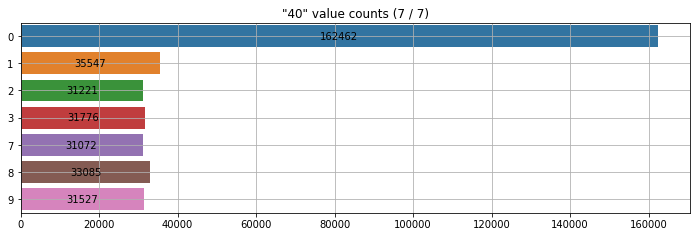

#### Test set Spoof labels

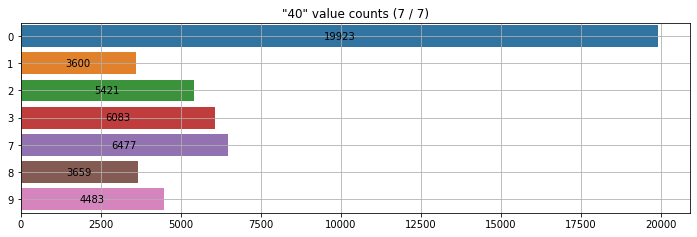

In [24]:
train_label, test_label = dp.read_orig_labels(CELEBA_DIR, spoof_filter)

display(Markdown('#### Train set Spoof labels'))
plot_value_counts(train_label[40], sort_index=True)
display(Markdown('#### Test set Spoof labels'))
plot_value_counts(test_label[40], sort_index=True)

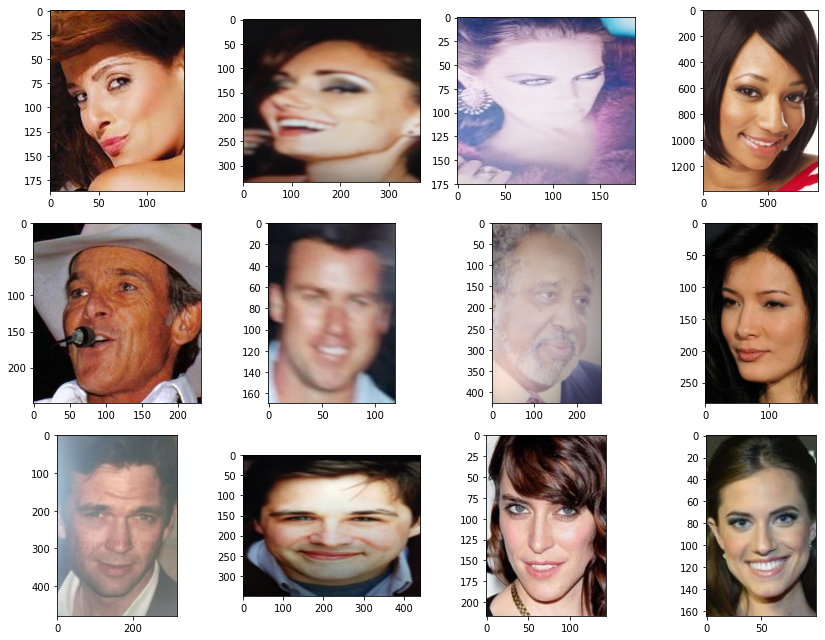

In [26]:
fig = plt.figure(figsize=(12,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    img = dp.read_image('/'.join([CELEBA_DIR, train_label.index[i]]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
plt.show()

In [4]:
del train_label, test_label

## Сlass balance

#### Binary classification: Live / Spoof

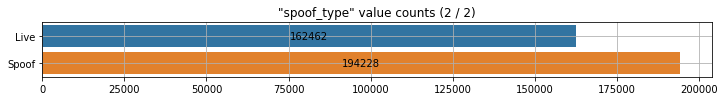

#### Live / Print attack / Replay attack

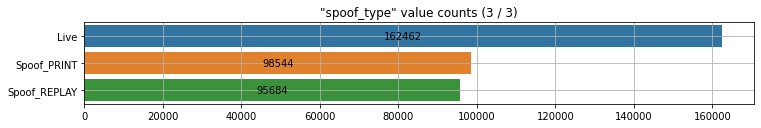

In [5]:
import pandas as pd
from config import TrainConfig

cnf = TrainConfig()
train_labels = pd.read_csv(cnf.labels_path)

def live_spoof(v):
    return 'Live' if v == 0 else 'Spoof'

def live_print_replay(v):
    if v in [1,2,3]:
        return 'Spoof_PRINT'
    if v in [7,8,9]:
        return 'Spoof_REPLAY'
    if v == 0:
        return 'Live'
    return 'other'

display(Markdown('#### Binary classification: Live / Spoof'))
spoofs = train_labels['spoof_type'].apply(lambda s: live_spoof(s))
plot_value_counts(spoofs, sort_index=True)

display(Markdown('#### Live / Print attack / Replay attack'))
spoofs = train_labels['spoof_type'].apply(lambda s: live_print_replay(s))
plot_value_counts(spoofs, sort_index=True)

## Testing data loader

In [1]:
from IPython.display import Markdown, display
import pandas as pd
from src.config import TrainConfig
from src.utility import plot_iter_images
from src.dataset_loader import get_train_valid_loader

In [3]:
cat = [[0],[1,2,3],[7,8,9]]
cnf = TrainConfig(spoof_categories=cat)
train_labels = pd.read_csv(cnf.labels_path)
spoof_transform = lambda t: next(i for i, l in enumerate(cat) if t in l)
train_labels.iloc[:,1] = train_labels.iloc[:,1].apply(spoof_transform)
value_counts = train_labels.iloc[:,1].value_counts()
train_downsampled = [train_labels[train_labels.iloc[:,1]==value_counts.index[-1]]]
for value in value_counts.index[:-1]:
    train_downsampled.append(
        train_labels[train_labels.iloc[:,1]==value].sample(
            value_counts.min()))
train_labels = pd.concat(train_downsampled)
train_labels.iloc[:,1].value_counts()

2    95684
0    95684
1    95684
Name: spoof_type, dtype: int64

### Binary classes: Live **0** and Spoof **1**

### Training loader example

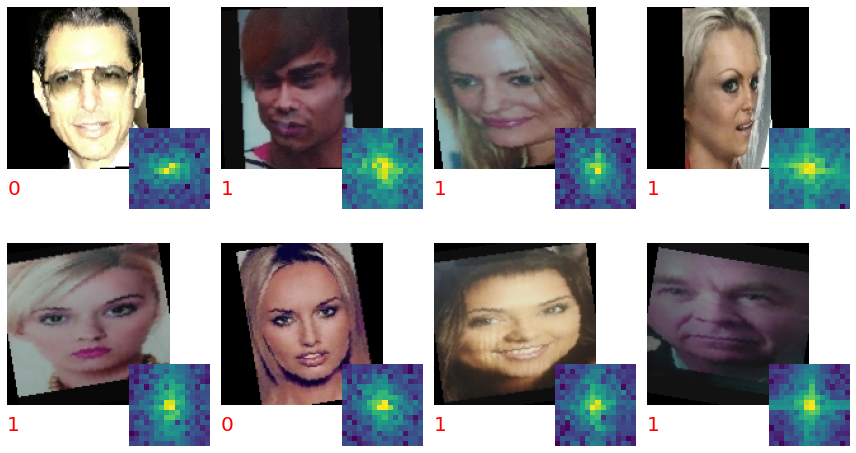

### Validation loader example

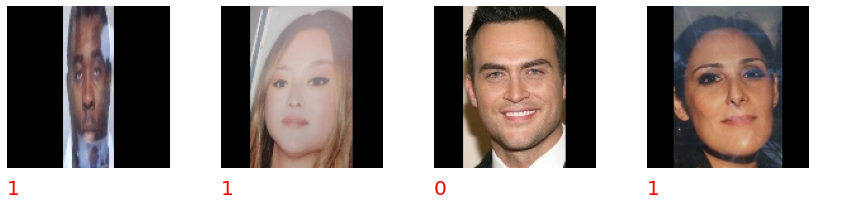

In [26]:
cnf = TrainConfig(spoof_categories='binary', batch_size=8)
train_loader, valid_loader = get_train_valid_loader(cnf)

display(Markdown('### Training loader example'))
plot_iter_images(iter(train_loader).next(), cnf.input_size, cnf.batch_size)
display(Markdown('### Validation loader example'))
plot_iter_images(iter(valid_loader).next(), cnf.input_size, 4)

### Live **0** / Print **1** / Replay **2**

### Training loader example

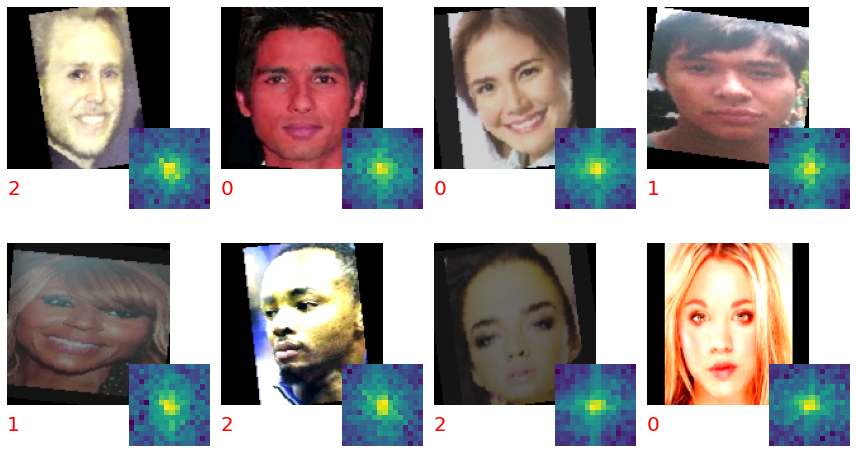

### Validation loader example

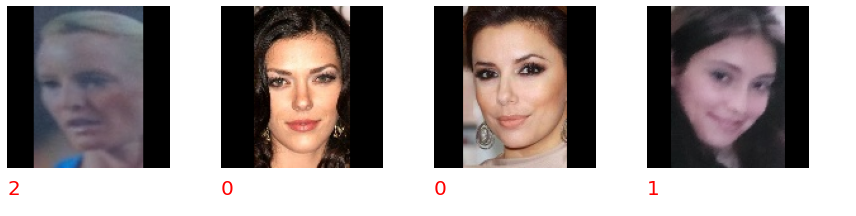

In [11]:
cnf = TrainConfig(spoof_categories=[[0],[1,2,3],[7,8,9]],
                  class_balancing='down', batch_size = 8)

train_loader, valid_loader = get_train_valid_loader(cnf)

display(Markdown('### Training loader example'))
plot_iter_images(iter(train_loader).next(), cnf.input_size, cnf.batch_size)
display(Markdown('### Validation loader example'))
plot_iter_images(iter(valid_loader).next(), cnf.input_size, 4)

## Testing Model

In [4]:
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (auc, roc_auc_score, accuracy_score, confusion_matrix,
                             precision_score, recall_score, f1_score, classification_report)
from src.config import TestConfig 
from src.antispoof_pretrained import AntiSpoofPretrained
from src.dataset_loader import get_test_loader
from src.utility import (roc_curve_plots, confusion_matricies_plots, 
                         multiclass_roc_curve_plots)
import time

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,Accuracy,AUC-ROC,Precision,Recall,F1 score,"Time, s"
Live / Spoof,0.9292,0.986919,0.974257,0.904714,0.938198,1.069804
Live / Print / Replay,0.9328,0.990246,0.982771,0.902694,0.941032,0.982012


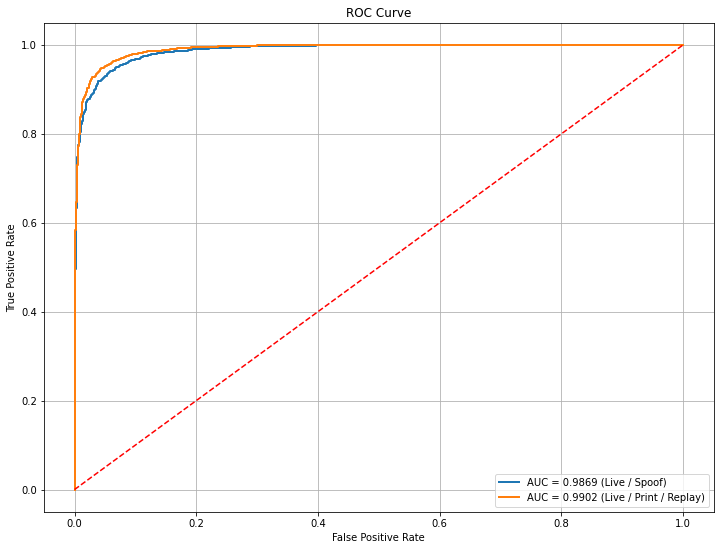

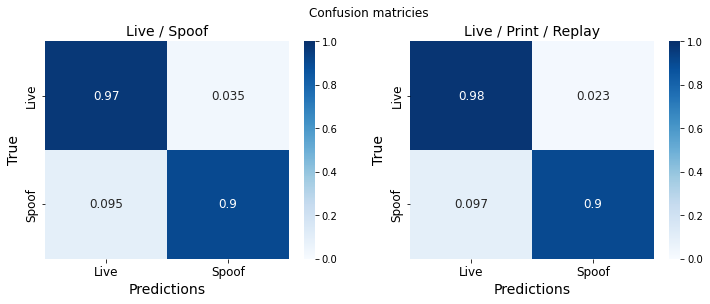

In [5]:
batches, batch_size = 10, 500
cnf_bin = TestConfig('saved_models/AntiSpoofing_bin_128.pth',
    batch_size=batch_size, spoof_categories='binary')
cnf_lpr = TestConfig('saved_models/AntiSpoofing_print-replay_128.pth',
    batch_size=batch_size, spoof_categories=[[0],[1,2,3],[7,8,9]])
models_loaders = {
    'Live / Spoof': (AntiSpoofPretrained(cnf_bin), get_test_loader(cnf_bin)), 
    'Live / Print / Replay' : (AntiSpoofPretrained(cnf_lpr), get_test_loader(cnf_lpr))}
models_proba = {}
model_results = {}
confusion_matricies = {}
for name, model_and_loader in models_loaders.items():
    model, loader = model_and_loader
    data_iter = iter(loader)

    target_all = np.array([])
    proba_all = np.array([])
    pred_all = np.array([])
    pred_time = 0 
    for i in tqdm(range(batches)):
        imgs, target = data_iter.next()
        
        start = time.time()
        proba = model.predict(imgs)
        pred_time += time.time() - start
        
        target_all = np.append(target_all, target.numpy())
        pred_all = np.append(pred_all, np.argmax(proba, axis=1))
        proba_all = np.append(proba_all, proba[:,1:].sum(axis=1))

    pred_bin = (~(pred_all == 0)).astype(int)
    target_bin = (~(target_all == 0)).astype(int)
    
    models_proba[name] = proba_all
    res = {'Accuracy' : accuracy_score(target_bin, pred_bin),
           'AUC-ROC'  : roc_auc_score(target_bin, proba_all),
           'Precision': precision_score(target_bin, pred_bin),
           'Recall'   : recall_score(target_bin, pred_bin),
           'F1 score' : f1_score(target_bin, pred_bin),
           'Time, s' : pred_time
    }
    model_results[name] = res
    confusion_matricies[name] = confusion_matrix(target_bin, pred_bin, normalize='true')    
    
display(pd.DataFrame(model_results).T)
roc_curve_plots(target_bin, models_proba)
confusion_matricies_plots(confusion_matricies, class_labels=['Live','Spoof'])

In [4]:
def test_print_replay_model(cnf, batches=10, batch_size=500):
    model = AntiSpoofPretrained(cnf)
    loader = get_test_loader(cnf)
    data_iter = iter(loader)
    target_all = np.array([])
    proba_all = np.empty([0, 3])
    pred_all = np.array([])
        
    for i in tqdm(range(batches)):
        imgs, target = data_iter.next()
        proba = model.predict(imgs)
        target_all = np.append(target_all, target.numpy())
        pred_all = np.append(pred_all, np.argmax(proba, axis=1))
        proba_all = np.append(proba_all, np.array(proba), axis=0)
    
    class_labels = ['Live','Print','Replay']

    display(pd.DataFrame(classification_report(target_all, pred_all, output_dict=True,
                                               target_names=class_labels)))
    print('AUC ROC one vs rest =', roc_auc_score(target_all, proba_all, multi_class='ovr'))
    print('AUC ROC one vs one  =', roc_auc_score(target_all, proba_all, multi_class='ovo'))
    multiclass_roc_curve_plots(target_all, proba_all, class_labels=class_labels)

    sns.heatmap(pd.DataFrame(confusion_matrix(target_all, pred_all, normalize='true')), 
                annot=True, cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":12})
    plt.xticks(np.arange(0.5,3), class_labels, fontsize=12)
    plt.yticks(np.arange(0.5,3), class_labels, fontsize=12)
    plt.title('Live / Print / Replay confusion matrix', fontsize=14)
    plt.xlabel('Predictions', fontsize=14), plt.ylabel('True', fontsize=14)
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

,Live,Print,Replay,accuracy,macro avg,weighted avg
precision,0.872799,0.879154,0.773504,0.8466,0.841819,0.846041
recall,0.976847,0.763279,0.751557,0.8466,0.830561,0.846600
f1-score,0.921897,0.817129,0.762373,0.8466,0.833799,0.843840
support,2030.000000,1525.000000,1445.000000,0.8466,5000.000000,5000.000000


AUC ROC one vs rest = 0.9587364308726142
AUC ROC one vs one  = 0.953749536166011


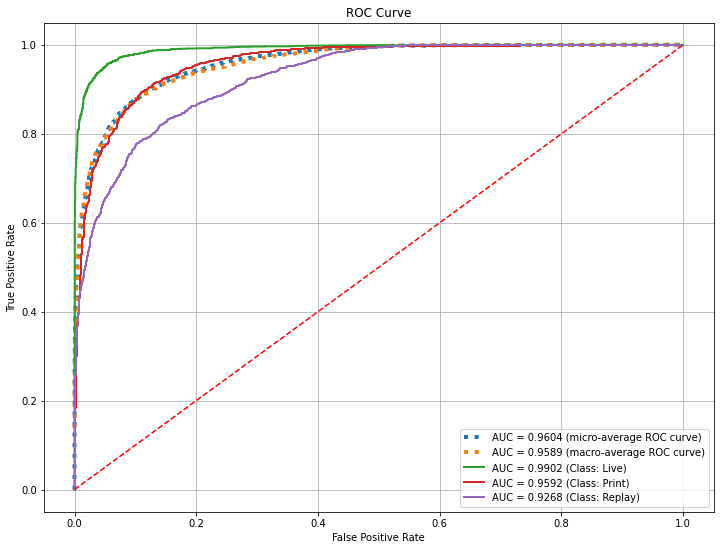

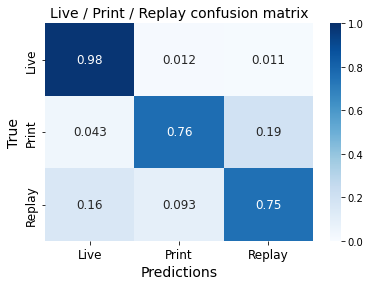

In [5]:
test_print_replay_model(TestConfig('saved_models/AntiSpoofing_print-replay_128.pth',
    batch_size=batch_size, spoof_categories=[[0],[1,2,3],[7,8,9]]))

  0%|          | 0/10 [00:00<?, ?it/s]

,Live,Print,Replay,accuracy,macro avg,weighted avg
precision,0.870724,0.893551,0.762654,0.845,0.842310,0.846454
recall,0.965517,0.754098,0.771626,0.845,0.830414,0.845000
f1-score,0.915674,0.817923,0.767114,0.845,0.833570,0.842926
support,2030.000000,1525.000000,1445.000000,0.845,5000.000000,5000.000000


AUC ROC one vs rest = 0.9581535323787119
AUC ROC one vs one  = 0.9538784006536476


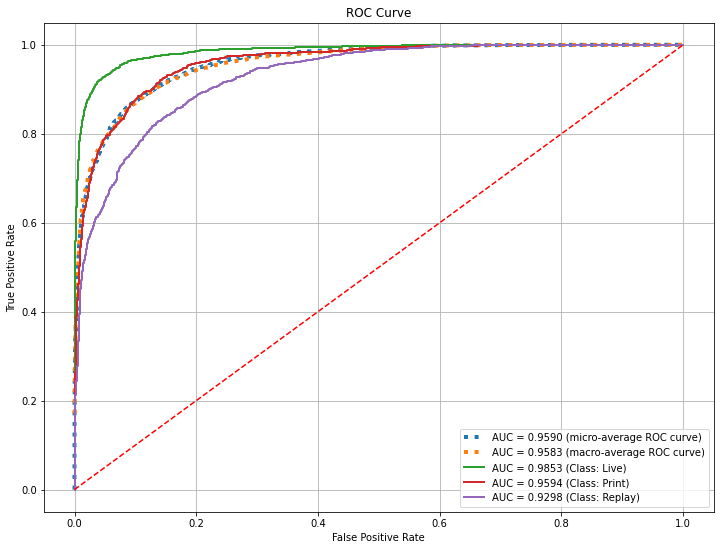

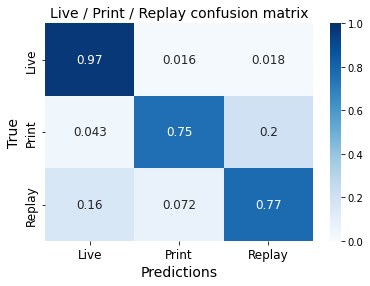

In [6]:
test_print_replay_model(TestConfig('saved_models/AntiSpoofing_print-replay_cb-down_128.pth',
    batch_size=batch_size, spoof_categories=[[0],[1,2,3],[7,8,9]]))